1. создаем виртуальное окружение с необходимыми библиотеками
<p><B>PIPY</B></p>

- python3 -m venv MLvenv
- source MLvenv/bin/activate
- pip install jupyter ipykernel scikit-learn pandas matplotlib seaborn
- python -m ipykernel install --user --name MLvenv --display-name "Python (MLvenv)" (регистрация окружения как ядро)
<p><B>CONDA</B></p>

- conda create -n MLvenv python=3.12
- conda activate MLvenv
- conda install jupyter ipykernel scikit-learn pandas matplotlib seaborn 
- python -m ipykernel install --user --name MLvenv --display-name "Conda_Python (MLvenv)" (регистрация окружения как ядро)
- jupyter notebook (bash)
2. импортируем необходимые библиотеки в выделенной ячейке для импортов

# Импорты библиотек

In [2]:
# --- Работа с данными ---
import numpy as np                                   # численные массивы и мат. операции
import pandas as pd                                  # работа с табличными данными

# --- Визуализация данных ---
import matplotlib.pyplot as plt                      # графики
import seaborn as sns                                # статистическая визуализация

# --- Препроцессинг и пайплайны ---
from sklearn.pipeline import Pipeline                # сборка последовательности трансформаций + модель
from sklearn.preprocessing import StandardScaler, MinMaxScaler # стандартизация признаков

# --- Модели ---
from sklearn.linear_model import LogisticRegression  # логистическая регрессия

# --- Разделение данных и кросс-валидация ---
from sklearn.model_selection import (
    GridSearchCV,                                    # сеточный поиск гиперпараметров
    RandomizedSearchCV,                              # случайный поиск гиперпараметров
    StratifiedKFold,                                 # стратифицированная кросс-валидация для поиска гиперпараметров
    train_test_split,                                # разделение данных на train/test
    learning_curve                                   # построение кривых обучения
)

# --- Метрики ---
from sklearn.metrics import (
    classification_report,                           # precision/recall/F1/accuracy 
    confusion_matrix,                                # матрица ошибок (TP, FP, TN, TN)
    precision_recall_curve                           # кривая precision-recall
)

# --- Статистические распределения для RandomizedSearchCV ---
from scipy.stats import loguniform, randint          # логарифмическое и целое распределения для сетки гиперпараметров

# Базовый алгоритм для построения ML

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(10)

,Academic Pressure,Study Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression
0,5.0,2.0,1,3.0,1.0,1
1,2.0,5.0,0,3.0,2.0,0
2,3.0,5.0,0,9.0,1.0,0
3,3.0,2.0,1,4.0,5.0,1
4,4.0,3.0,1,1.0,1.0,0
5,2.0,3.0,0,4.0,1.0,0
6,3.0,4.0,0,1.0,2.0,0
7,2.0,4.0,0,0.0,1.0,0
8,3.0,1.0,1,12.0,3.0,1
9,2.0,3.0,1,2.0,5.0,1


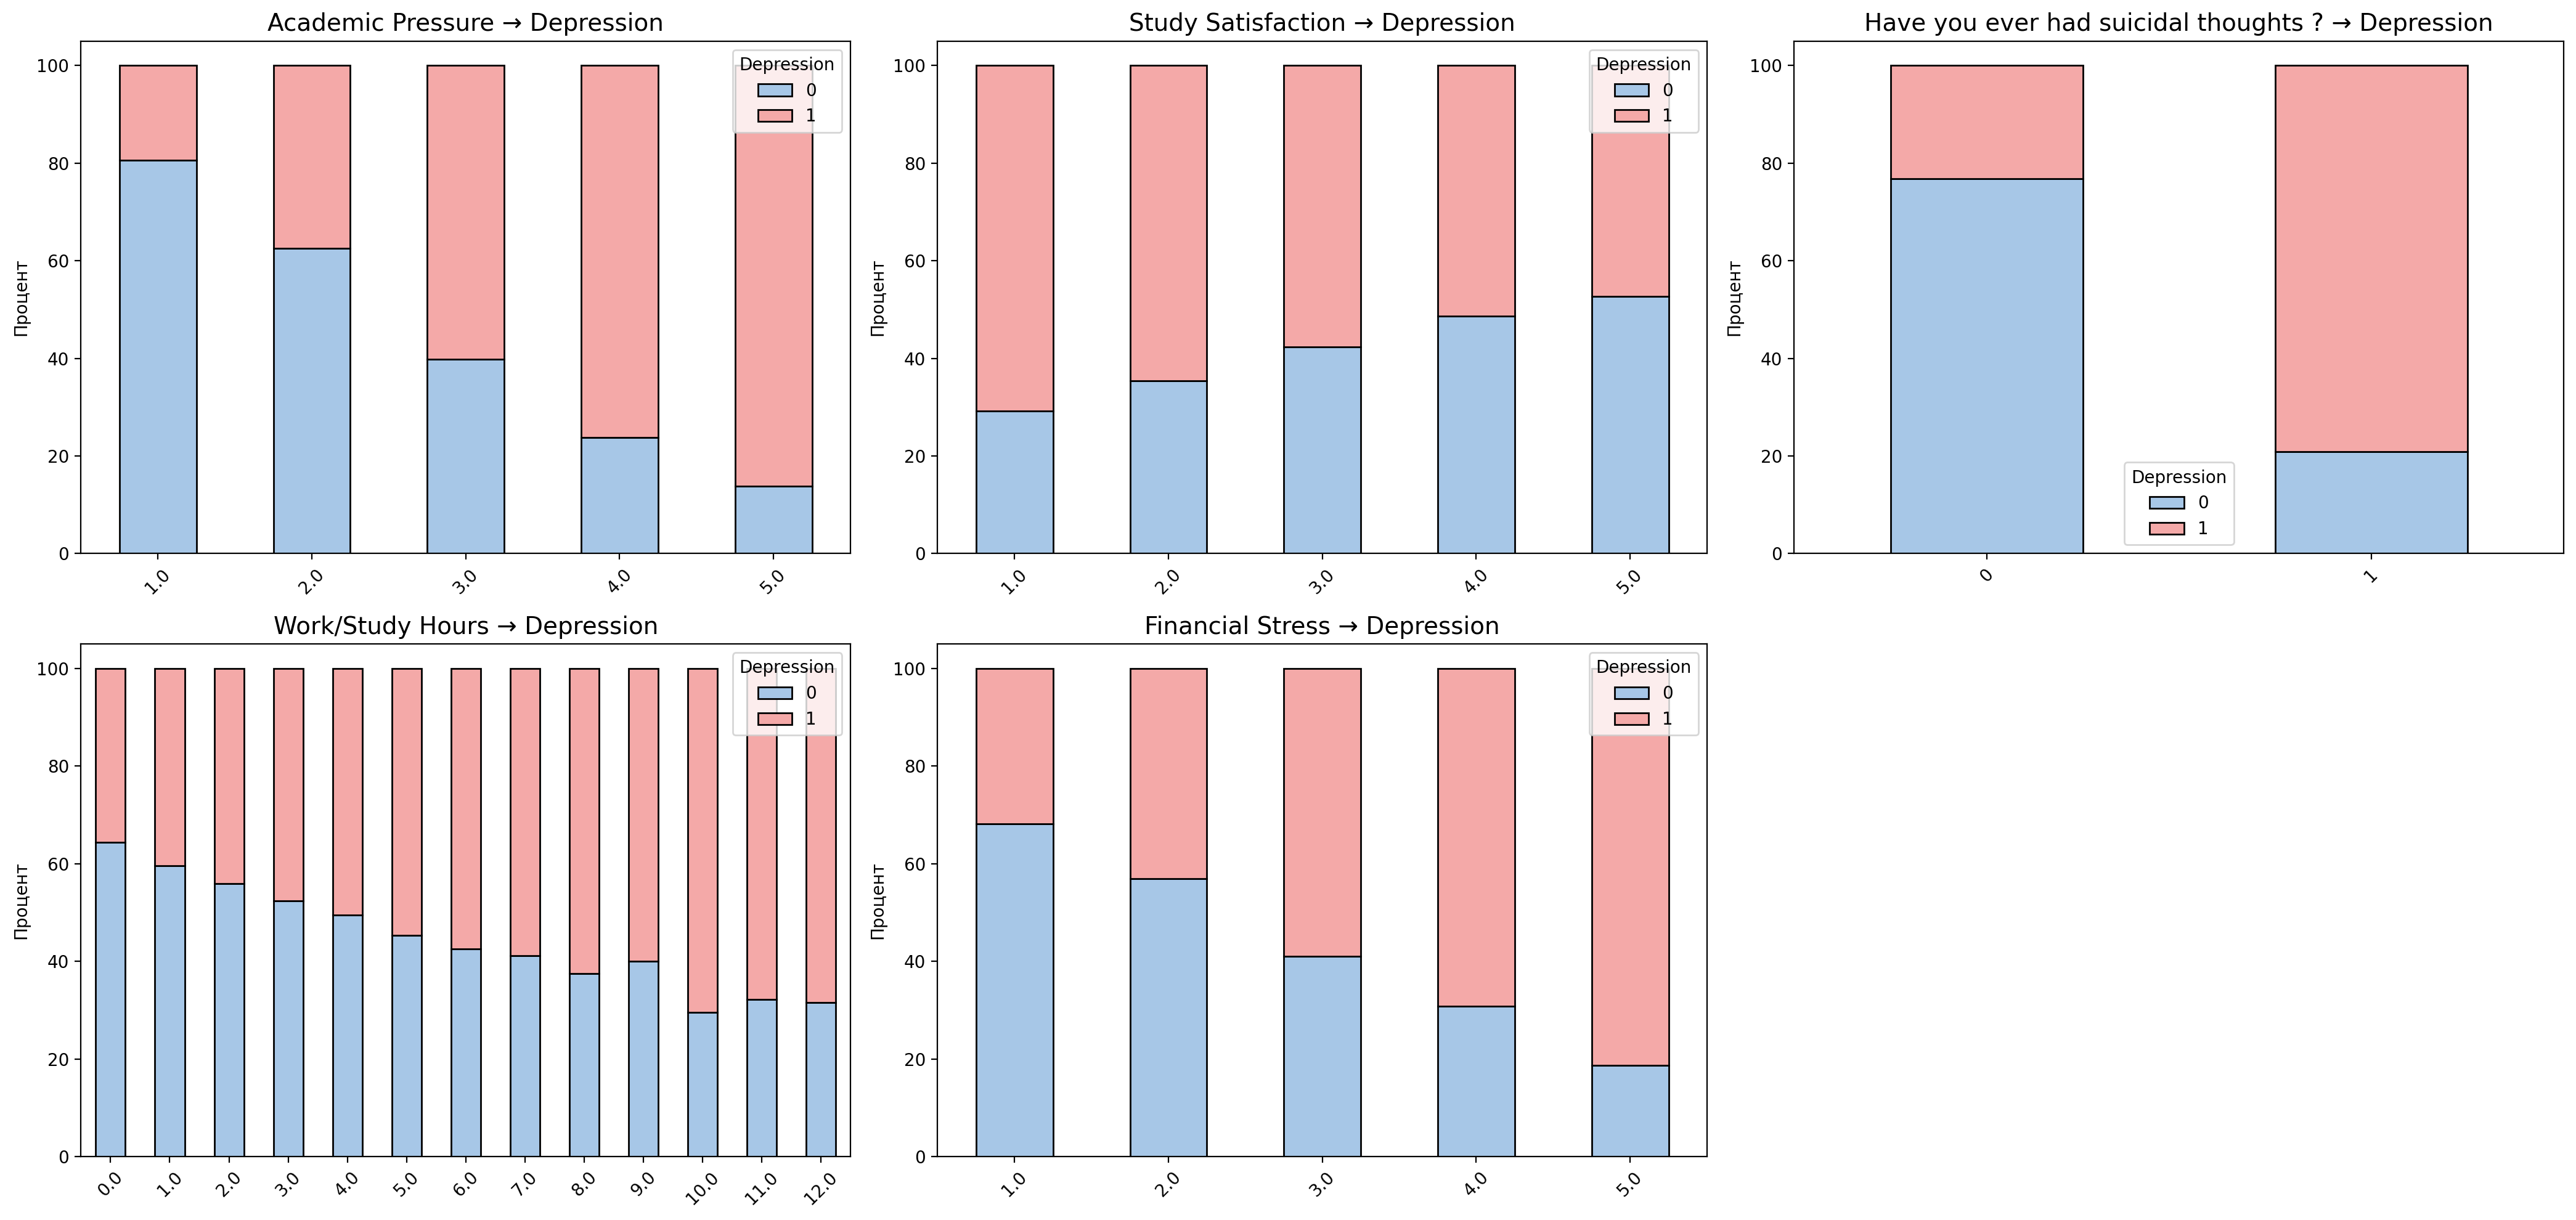

In [5]:
colors = ["#a7c7e7", "#f4a9a8"]

features = [
    'Academic Pressure',
    'Study Satisfaction',
    'Have you ever had suicidal thoughts ?',
    'Work/Study Hours',
    'Financial Stress'
]

target = 'Depression'

fig, axes = plt.subplots(2, 3, figsize=(21, 10), dpi=200)
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]

    # Частоты в %
    crosstab = pd.crosstab(df[col], df[target], normalize='index') * 100

    crosstab.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=colors,
        edgecolor='black'
    )

    ax.set_title(f"{col} → Depression", fontsize=14)
    ax.set_ylabel("Процент")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

if len(features) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# --- Разделение данных ---
X = df[[
    'Academic Pressure',
    'Study Satisfaction',
    'Have you ever had suicidal thoughts ?',
    'Work/Study Hours',
    'Financial Stress',
]] # Признаки
y = df['Depression'] # Целевая переменная


In [7]:
# train_test_split - база разделения данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Простой вариант обучения и оценки модели
# --- Обучение модели ---
model = LogisticRegression(max_iter=800)
model.fit(X_train, y_train)

# --- Предсказания ---
y_pred = model.predict(X_test)

# --- Оценка качества ---
# --- Classification Report ---
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.79      2302
           1       0.84      0.88      0.86      3260

    accuracy                           0.83      5562
   macro avg       0.83      0.82      0.82      5562
weighted avg       0.83      0.83      0.83      5562



# Полный алгоритм обучения и оценки модели

    Загрузка данный и разделение выборок

In [9]:
df = pd.read_csv('data.csv')

random_state = 42 # Случайное число для воспроизводимости результатов
test_size = 0.2 # Доля тестовой выборки

# --- Разделение данных ---
X = df[[
    'Academic Pressure',
    'Study Satisfaction',
    'Have you ever had suicidal thoughts ?',
    'Work/Study Hours',
    'Financial Stress',
]] # Признаки

y = df['Depression'] # Целевая переменная

# train_test_split - база разделения данных (обязательно stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

In [10]:
# Выводим размеры полученных выборок
print("Размерность тренировочной выборки признаков:", X_train.shape)
print("Размерность тестовой выборки признаков:", X_test.shape)

print("\n1. В исходном датафрейме df:")
print(y.value_counts())

Размерность тренировочной выборки признаков: (22245, 5)
Размерность тестовой выборки признаков: (5562, 5)

1. В исходном датафрейме df:
Depression
1    16299
0    11508
Name: count, dtype: int64


    Подбор лучших гиперпараметров модели (Pipeline c моделью) в RandomizedSearchCV

In [23]:
n_splits = 5 # Количество фолдов для кросс-валидации
metric = 'f1' # Метрика для подбора гиперпараметров
n_iter = 30 # Количество итераций для RandomizedSearch
n_jobs=-1 # Количество ядер для параллельных вычислений


# --- Pipeline: масштабирование + логистическая регрессия ---
pipe = Pipeline([
    ('scaler', MinMaxScaler()), # Стандартизация и другие трансформации (SimpleImputer) данных внутри Pipeline, что исключает утечку Data Leakage
    ('clf', LogisticRegression(random_state=random_state)) # Сама логистическая регрессия. Можно прописать любой другой классификатор
])

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state) # Стратифицированная кросс-валидация для подбора гиперпараметров

# --- Пространство гиперпараметров для RandomizedSearch ---
param_dist = {
    'scaler': [
        MinMaxScaler(), 
        StandardScaler(), 
        None,
        'passthrough'
    ],

    'clf__C': loguniform(1e-4, 1e2),          # сила регуляризации
    'clf__solver': ['saga', 'liblinear'],     # оптимизатор
    'clf__penalty': ['l1', 'l2'],             # Тип регуляции 
    'clf__class_weight': [None, 'balanced'],  # Критично при дисбалансе (в данном случае выраженного дисбаланса нет, но пусть будет)
    'clf__max_iter': randint(1000, 5000),     # число итераций
    'clf__tol': loguniform(1e-5, 1e-2)        # Точность сходимости
}

In [24]:
# Запуск RandomizedSearch для подбора гиперпараметров
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=n_iter,
    scoring=metric,
    cv=cv,
    n_jobs=n_jobs,
    random_state=random_state,
    verbose=1,  # 0 — нет вывода, 1 — прогресс, 2 — подробные логи, >=3 — очень подробные
    return_train_score=True,
    refit=True
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print(f"Best CV {metric}:", random_search.best_score_)

best_model = random_search.best_estimator_ # Лучшая модель (Pipeline с scaler и clf) после подбора гиперпараметров
print(best_model)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'clf__C': np.float64(0.017670169402947963), 'clf__class_weight': None, 'clf__max_iter': 2294, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'clf__tol': np.float64(0.0006251373574521745), 'scaler': None}
Best CV f1: 0.8611459490194235
Pipeline(steps=[('scaler', None),
                ('clf',
                 LogisticRegression(C=np.float64(0.017670169402947963),
                                    max_iter=2294, penalty='l1',
                                    random_state=42, solver='liblinear',
                                    tol=np.float64(0.0006251373574521745)))])


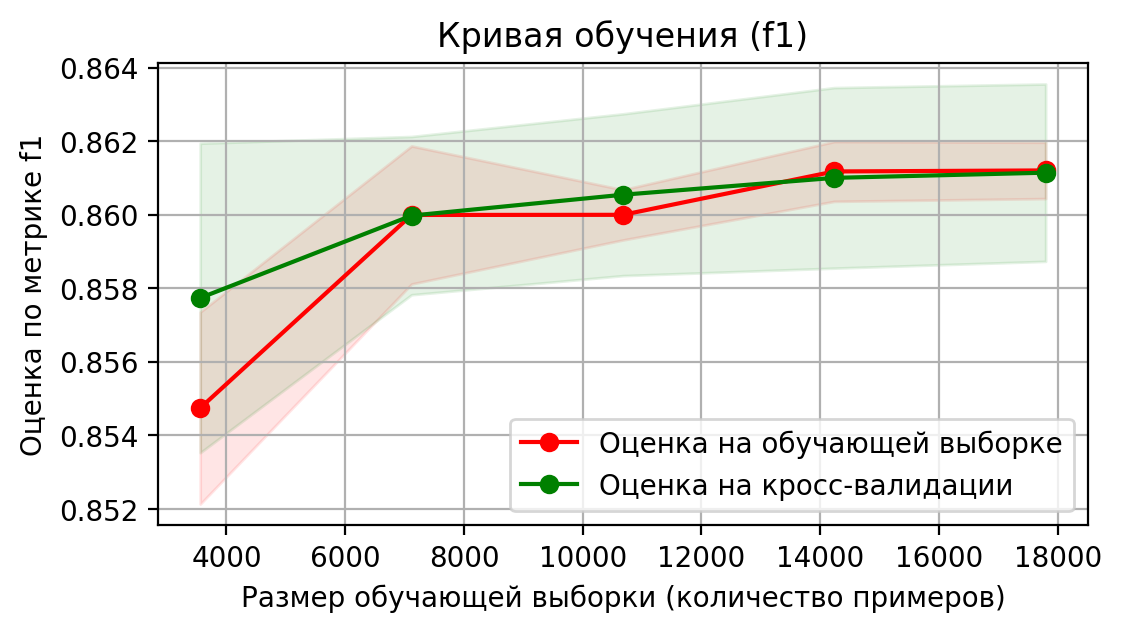

In [25]:
# График кривой обучения для оценки производительности модели sklearn.model_selection learning_curve
# Помогает определить передобучение и недообучение модели
train_sizes=np.linspace(0.2, 1.0, 5)

# Функция возвращает размеры выборок, оценки на обучающей выборке и оценки на кросс-валидации.
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=metric,
    n_jobs=n_jobs,
    train_sizes=train_sizes,
    random_state=random_state
)

# 3. Расчет средних и стандартных отклонений
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 4. Визуализация
plt.figure(figsize=(6, 3), dpi=200)
plt.title(f"Кривая обучения ({metric})")
plt.xlabel("Размер обучающей выборки (количество примеров)")
plt.ylabel(f"Оценка по метрике {metric}")
plt.grid()

# Заливка области стандартного отклонения (разброса) для обучающей выборки
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")

# Заливка области стандартного отклонения (разброса) для CV-выборки
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Построение средних значений
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Оценка на обучающей выборке")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Оценка на кросс-валидации")

plt.legend(loc="best")
plt.show()

In [26]:
# --- Финальное обучение best_model на всем train + оценка на test ---
print("-" * 50)
print("Финальная оценка модели на X_test:")
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nClassification report (test):")
print(classification_report(y_test, y_pred))

--------------------------------------------------
Финальная оценка модели на X_test:

Classification report (test):
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      2302
           1       0.84      0.89      0.86      3260

    accuracy                           0.83      5562
   macro avg       0.83      0.82      0.83      5562
weighted avg       0.83      0.83      0.83      5562



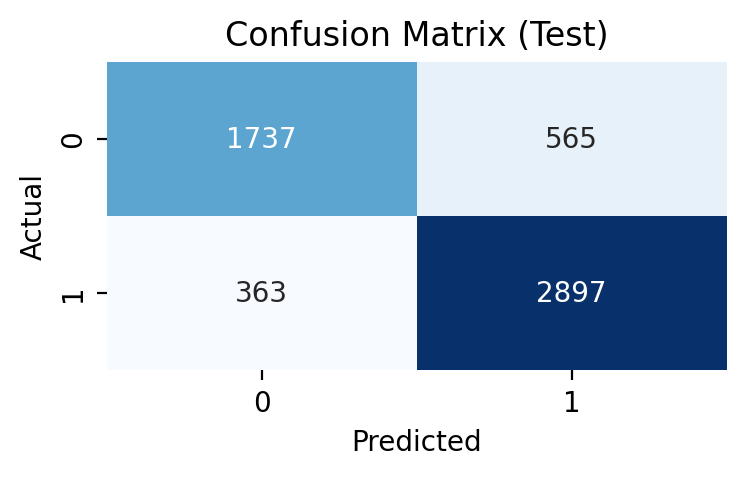

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 2), dpi=200)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()

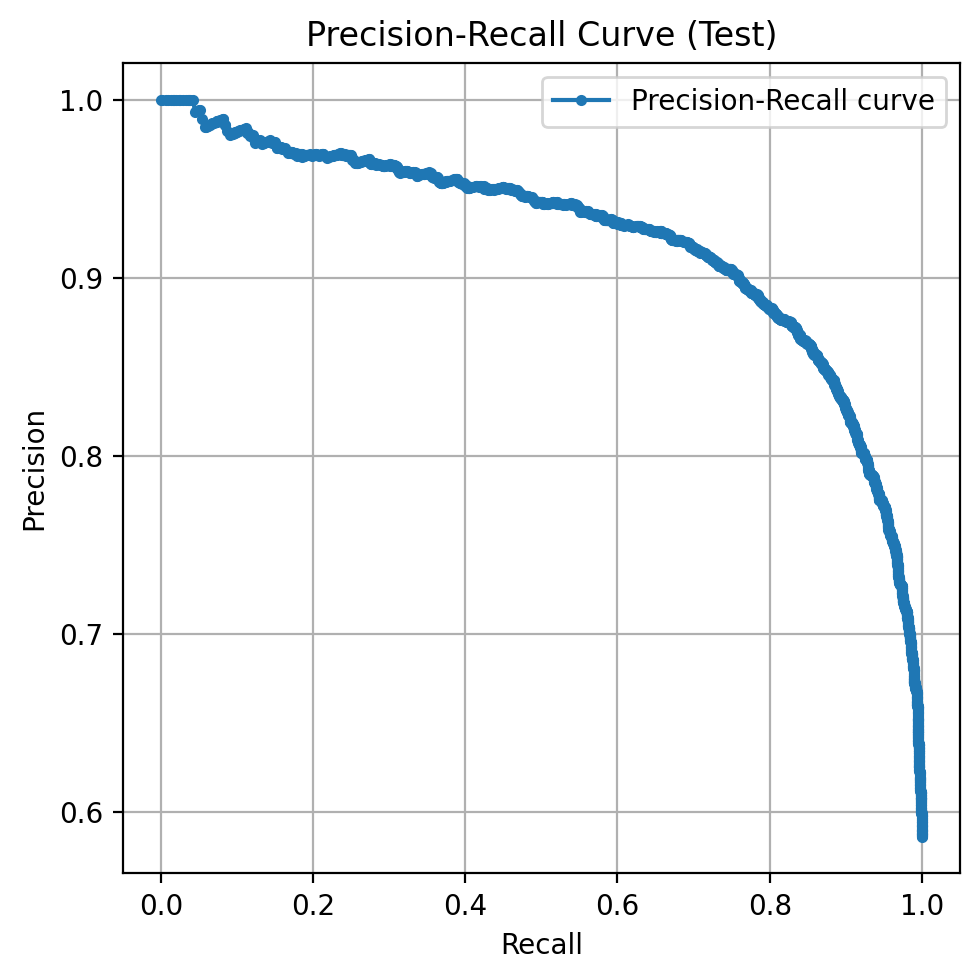

In [28]:
y_proba = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5, 5), dpi=200)
plt.plot(recalls, precisions, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                                 feature  coefficient
2  Have you ever had suicidal thoughts ?     2.297569
0                      Academic Pressure     0.750991
4                       Financial Stress     0.507361
3                       Work/Study Hours     0.096290
1                     Study Satisfaction    -0.253750


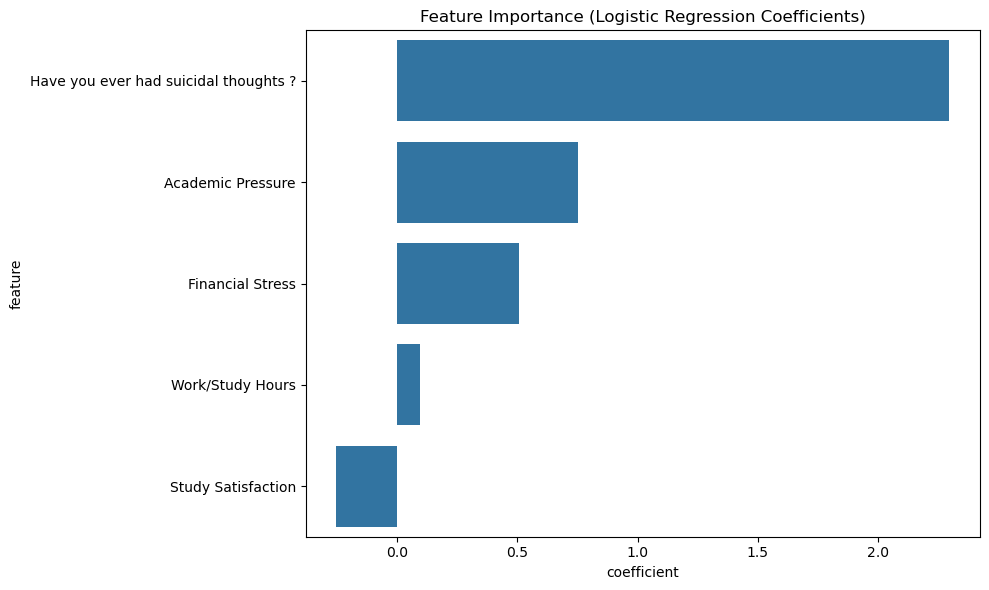

In [29]:
# Коэффициенты логистической регрессии
feature_names = [
    'Academic Pressure',
    'Study Satisfaction',
    'Have you ever had suicidal thoughts ?',
    'Work/Study Hours',
    'Financial Stress',
]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': best_model.named_steps['clf'].coef_[0]
})
coef_df = coef_df.sort_values('coefficient', ascending=False)
print(coef_df)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='coefficient', y='feature')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()

# Интерпретация модели (SHAP-анализ)

pip/conda install shap

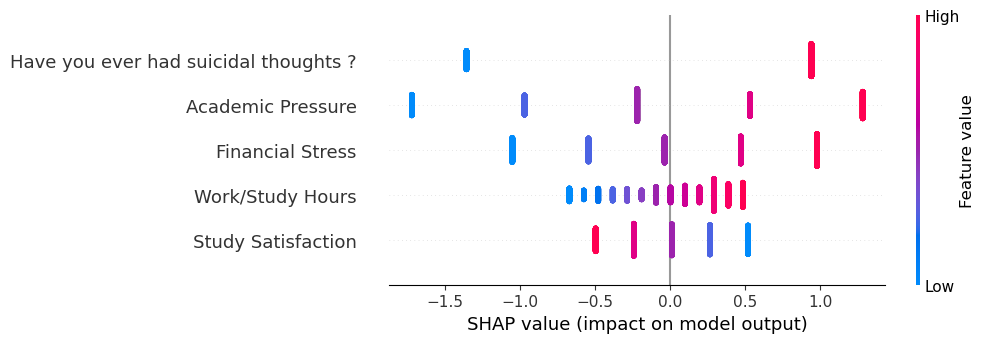

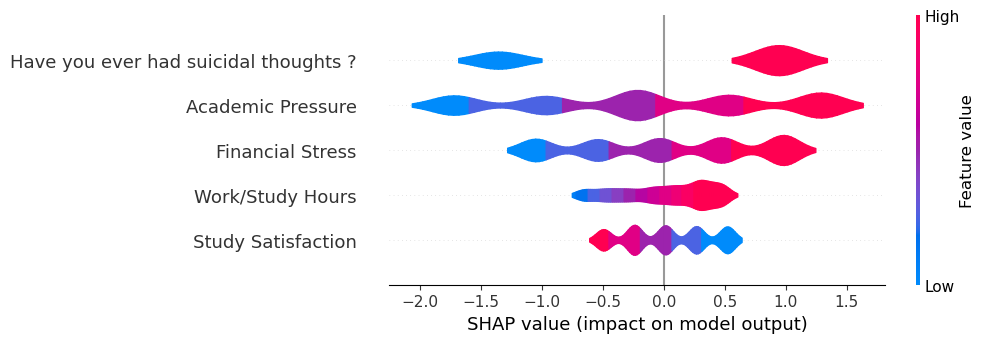

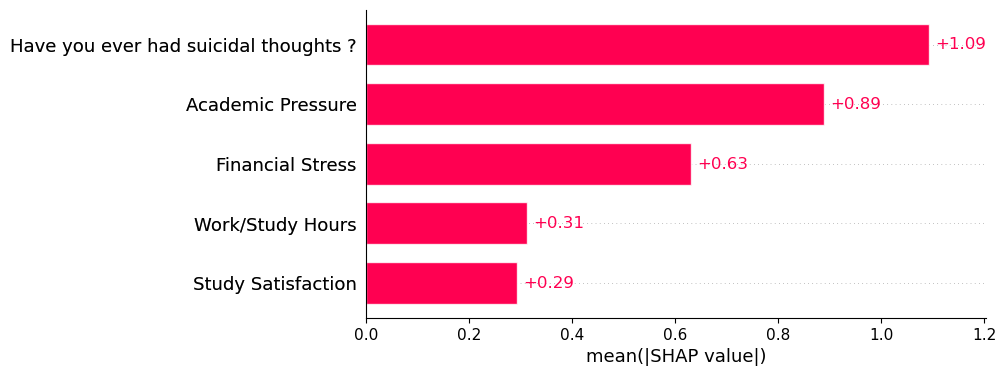

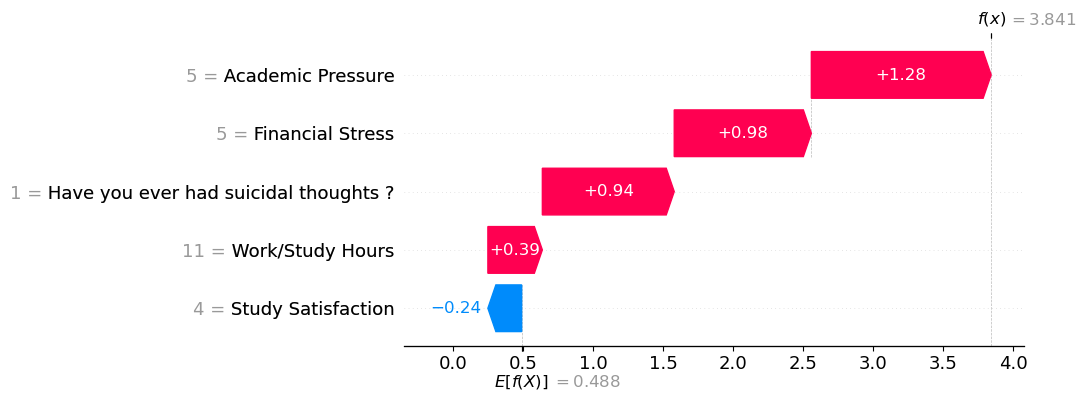

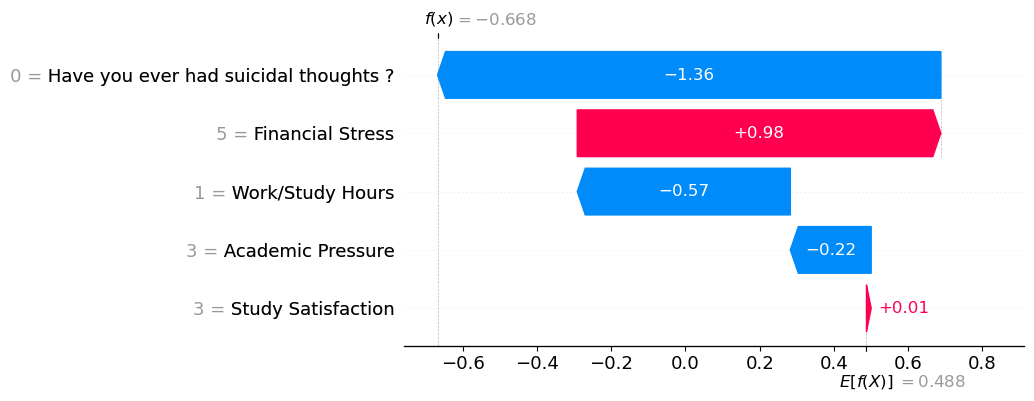

In [34]:
import shap

# Масштабируем данные
# X_train_scaled = best_model.named_steps['scaler'].transform(X_train)
# X_test_scaled = best_model.named_steps['scaler'].transform(X_test)

# LinearExplainer для логистической регрессии
explainer = shap.LinearExplainer(best_model.named_steps['clf'], X_train)

# Получаем shap_values (numpy)
shap_values_np = explainer.shap_values(X_test)

# Преобразуем в объект Explanation
shap_values = shap.Explanation(values=shap_values_np,
                               base_values=explainer.expected_value,
                               data=X_test,
                               feature_names=X_test.columns.tolist())

# Теперь можно строить визуализации
shap.plots.beeswarm(shap_values)
shap.plots.violin(shap_values)
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1000])